# Oct 13-14 Science Pipelines Hack Day

Notebook by Meredith Rawls, largely created during the hack day/tutorial (DM-32035), with followup steps and clarifying comments added retroactively. 

What we did:
* Largely followed the guide at https://pipelines.lsst.io/v/weekly/getting-started/dc2-guide.html
* Used previously-made coadds from one of Meredith's collections as templates for difference imaging (these were constructed via a pipeline akin to `ApTemplate-DC2.yaml`, which we inspected)
* Wrote `ApPipe-DC2.yaml` and ran it on a single patch from the command line, to an sqlite APDB
* Inspected the output from that small run in this notebook, largely through plotting things in the APDB that were loaded into pandas dataframes
* Wrote `ApPipe-DC2-bps.yaml` and used it to process all patches in a tract from bps, to a postgres APDB

In [2]:
%matplotlib notebook
# only if you're in "standard" Jupyter notebooks, not JupyterLab
#%matplotlib widget  # another option
#%matplotlib inline  # another option, plots will be non-interactive

# We probably won't use all these imports, but we could...

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

In [3]:
# Special python scripts that live in github.com/lsst-dm/ap_pipe-notebooks
# Eventually they will move to ap_analysis and come along with the rest of the science pipelines software

sys.path.append('/project/mrawls/ap_pipe-notebooks')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

In [ ]:
# Only need to execute this cell if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)
importlib.reload(plc)
importlib.reload(coa)

In [4]:
repo = '/repo/dc2'
butler = dafButler.Butler(repo)
collection = 'u/mrawls/DM-32035-mini'
#collection = 'u/aheinze/OctHack01a'  # the output collection you want to use

In [5]:
dbName = '/project/mrawls/2021-oct-hackday/association.db'
#dbName = '/project/aheinze/2021-oct-hackday/association.db'  # the sqlite APDB corresponding to collection above
instrument = 'LSSTCam-imSim'

In [6]:
# Load DiaObjects and DiaSources into pandas dataframes
# The ones called "good" exclude all DiaSources with one or more "bad" flags
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                      dbType='sqlite',
                                                      dbName=dbName,
                                                      gen='gen3',
                                                      instrument=instrument)

In [7]:
# Unpack the binary flags into one column per flag
flagTable, srcTableFlags, flagFilter, \
goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable, gen='gen3',
                                         instrument=instrument, repo=repo)

In [8]:
print(len(objTable), len(srcTable))

666 1116


<IPython.core.display.Javascript object>


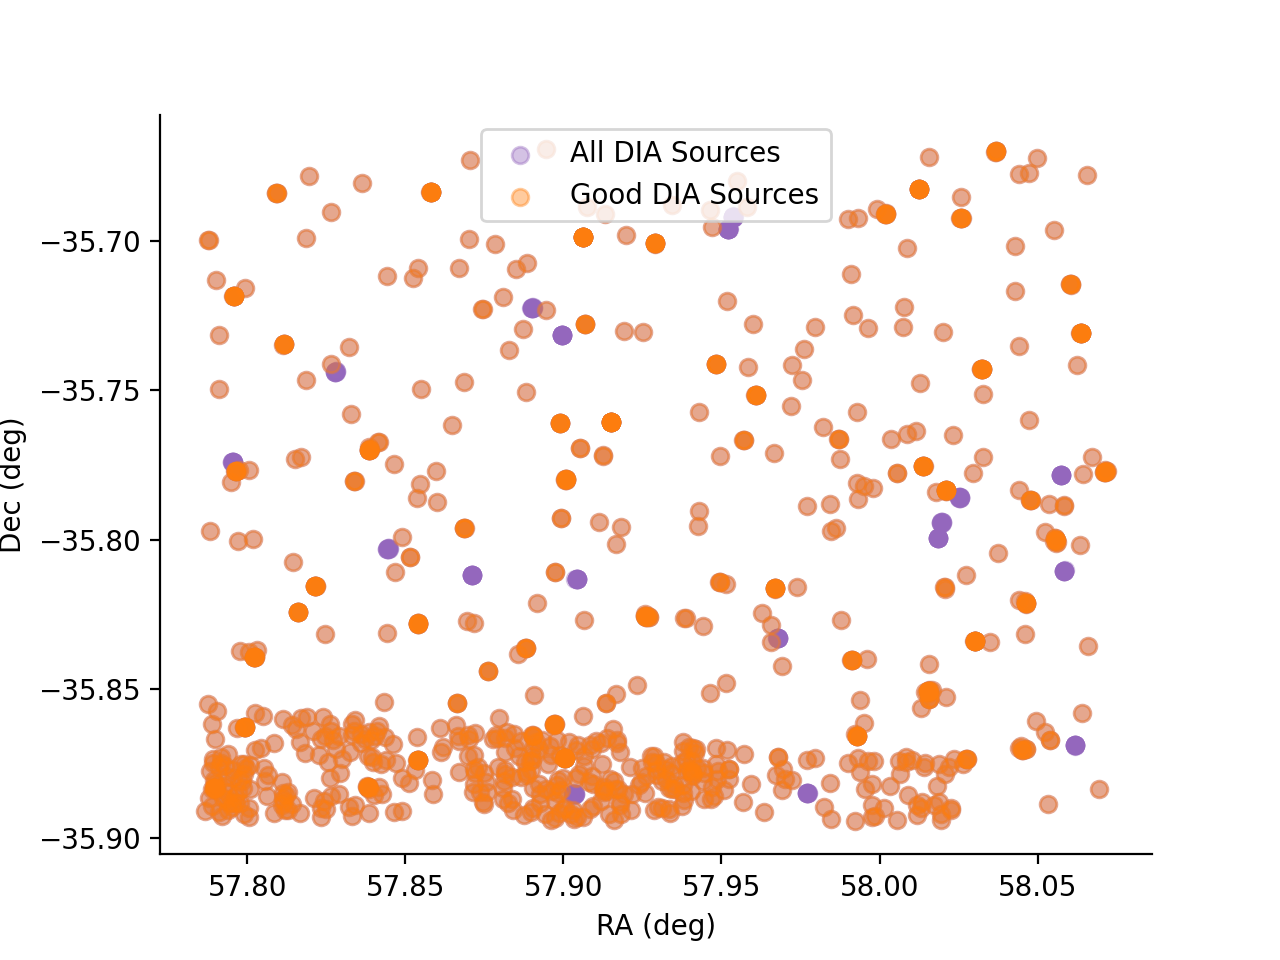

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(srcTable.ra, srcTable.decl, c='C4', alpha=0.4, label="All DIA Sources")
ax.scatter(goodSrc.ra, goodSrc.decl, c='C1', alpha=0.4, label="Good DIA Sources")
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
plt.legend()

<IPython.core.display.Javascript object>


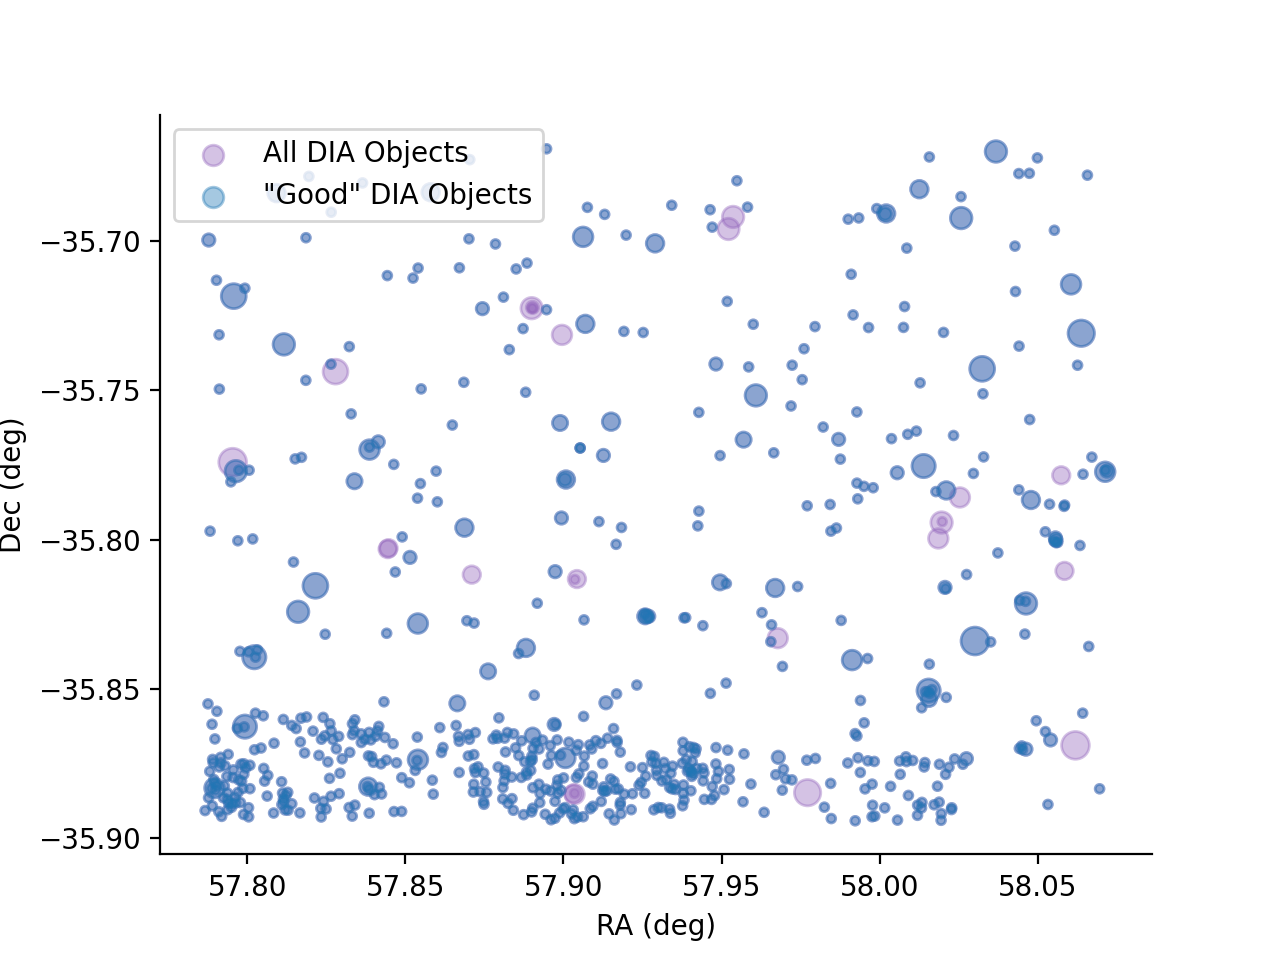

In [10]:
# pandas equivalent: thing.ra or thing['ra']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(objTable.ra, objTable.decl, c='C4', s=objTable['nDiaSources']*10,
           alpha=0.4, label='All DIA Objects')
ax.scatter(goodObj.ra, goodObj.decl, c='C0', s=goodObj['nDiaSources']*10,
           alpha=0.4, label='"Good" DIA Objects')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
plt.legend()

<IPython.core.display.Javascript object>


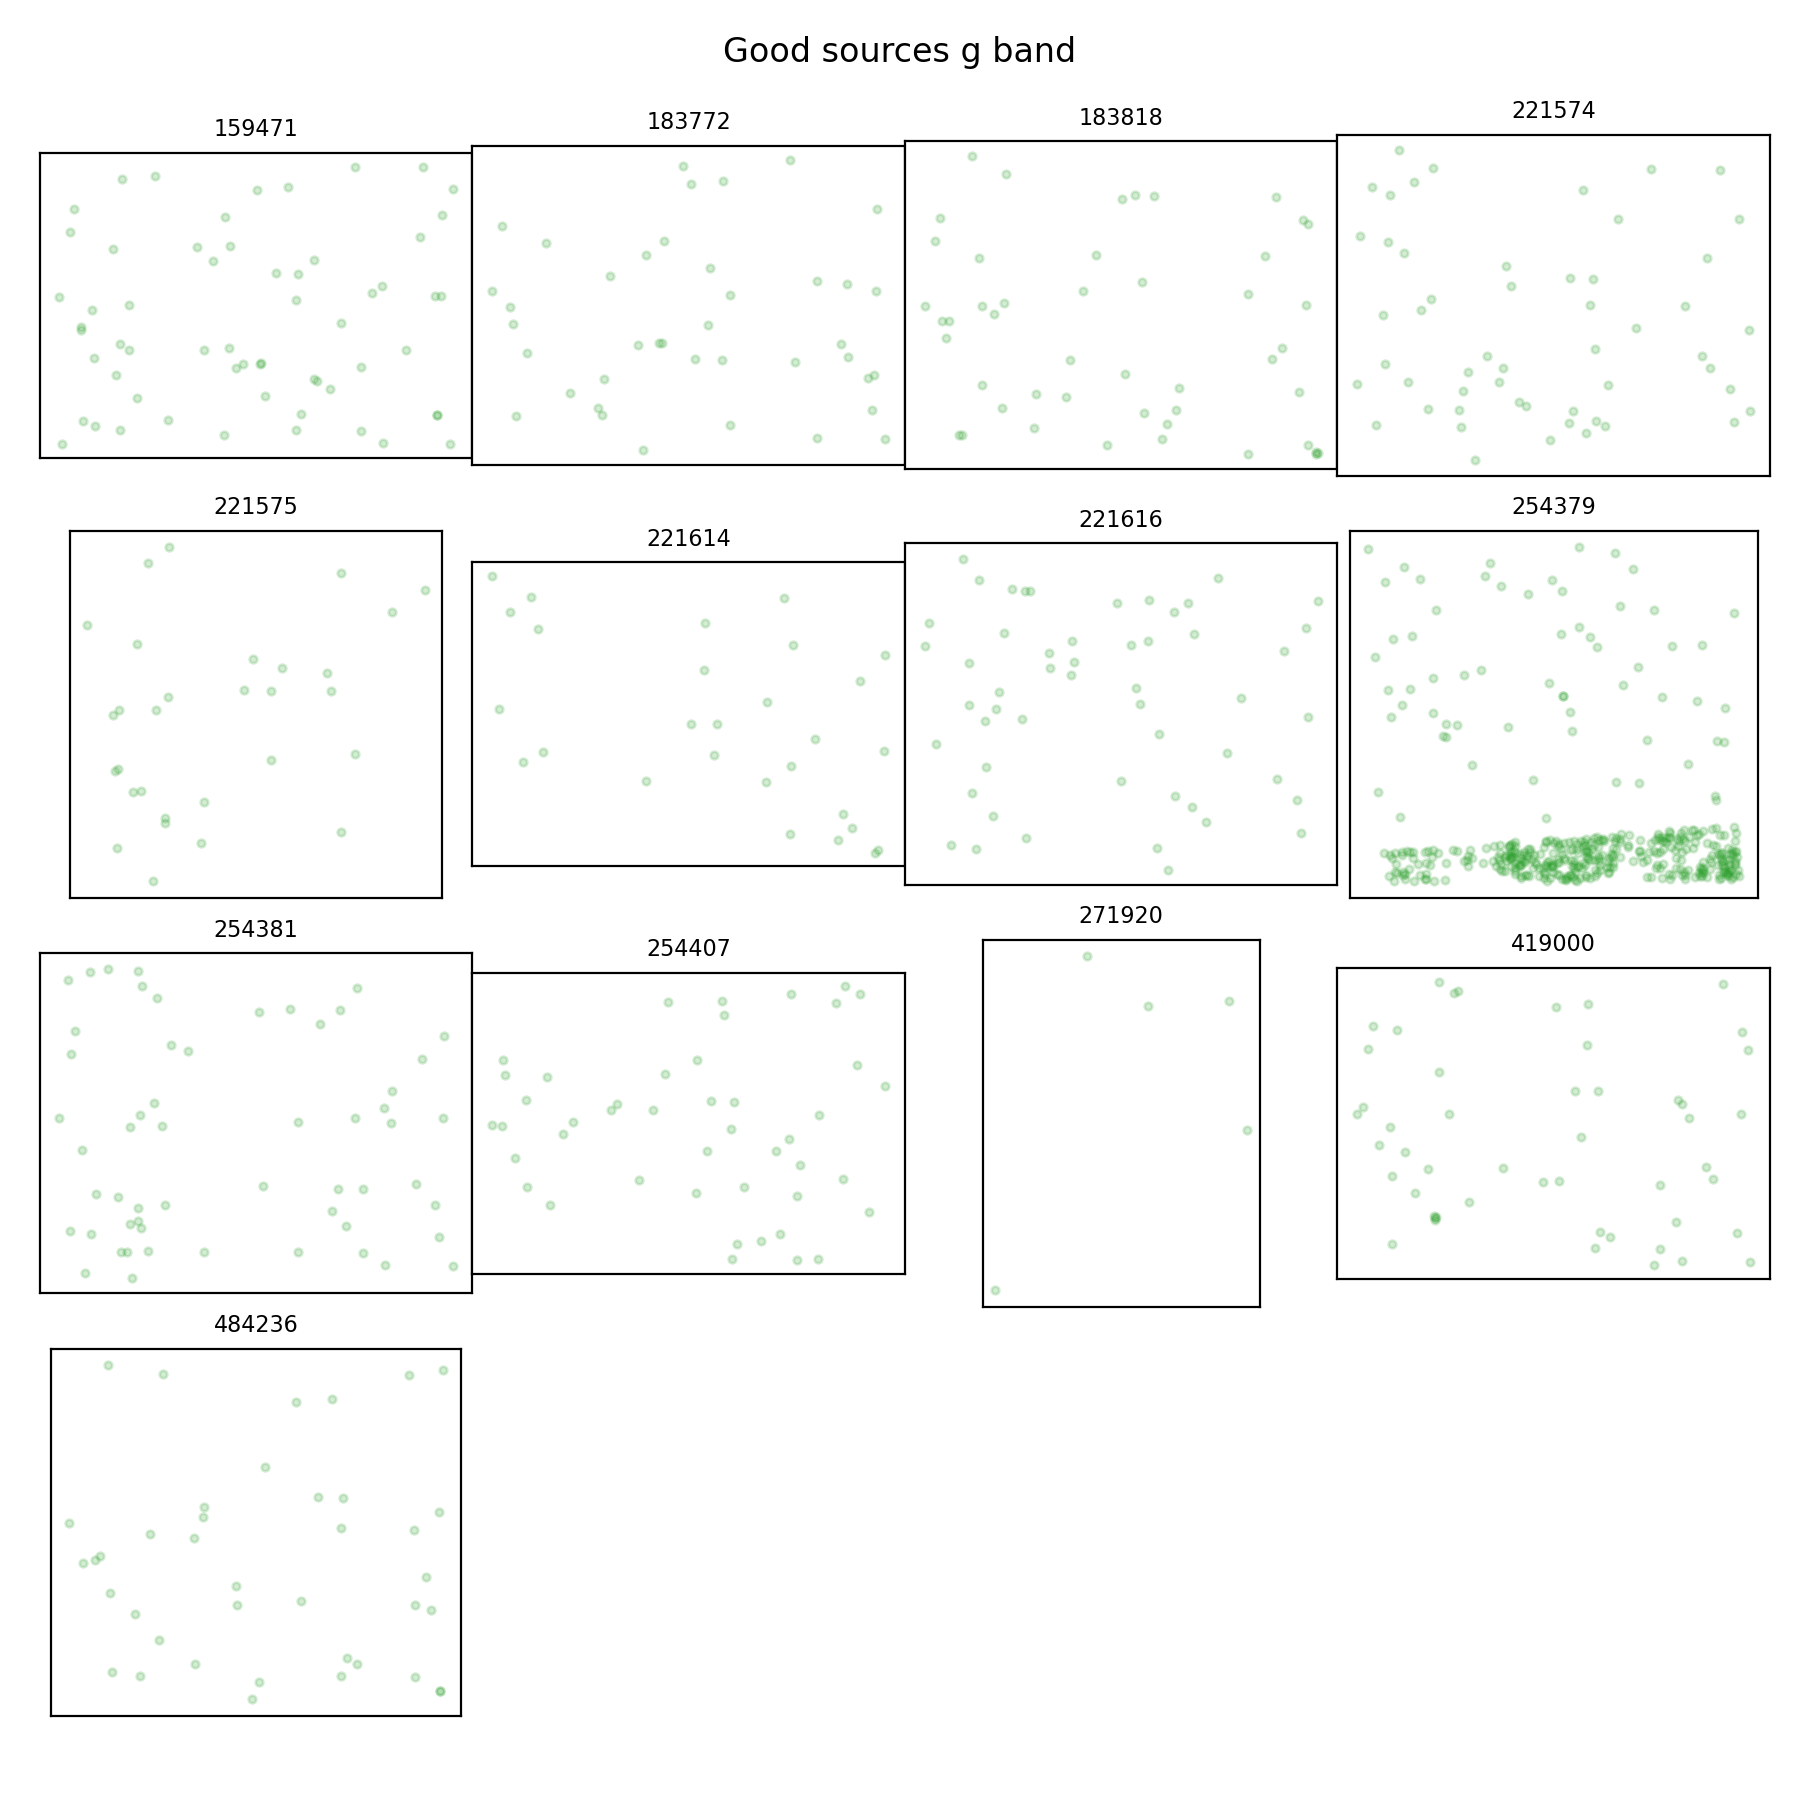

In [11]:
# Plot DiaSources on a per-visit basis (we only processed g-band data)
pla.plotDiaSourcesOnSkyGrid(repo, goodSrc, title='Good sources g band',
                            color='C2', size=30)

In [12]:
# Expand the default list of bad flags a little bit, and look at the flag distribution
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

<IPython.core.display.Javascript object>


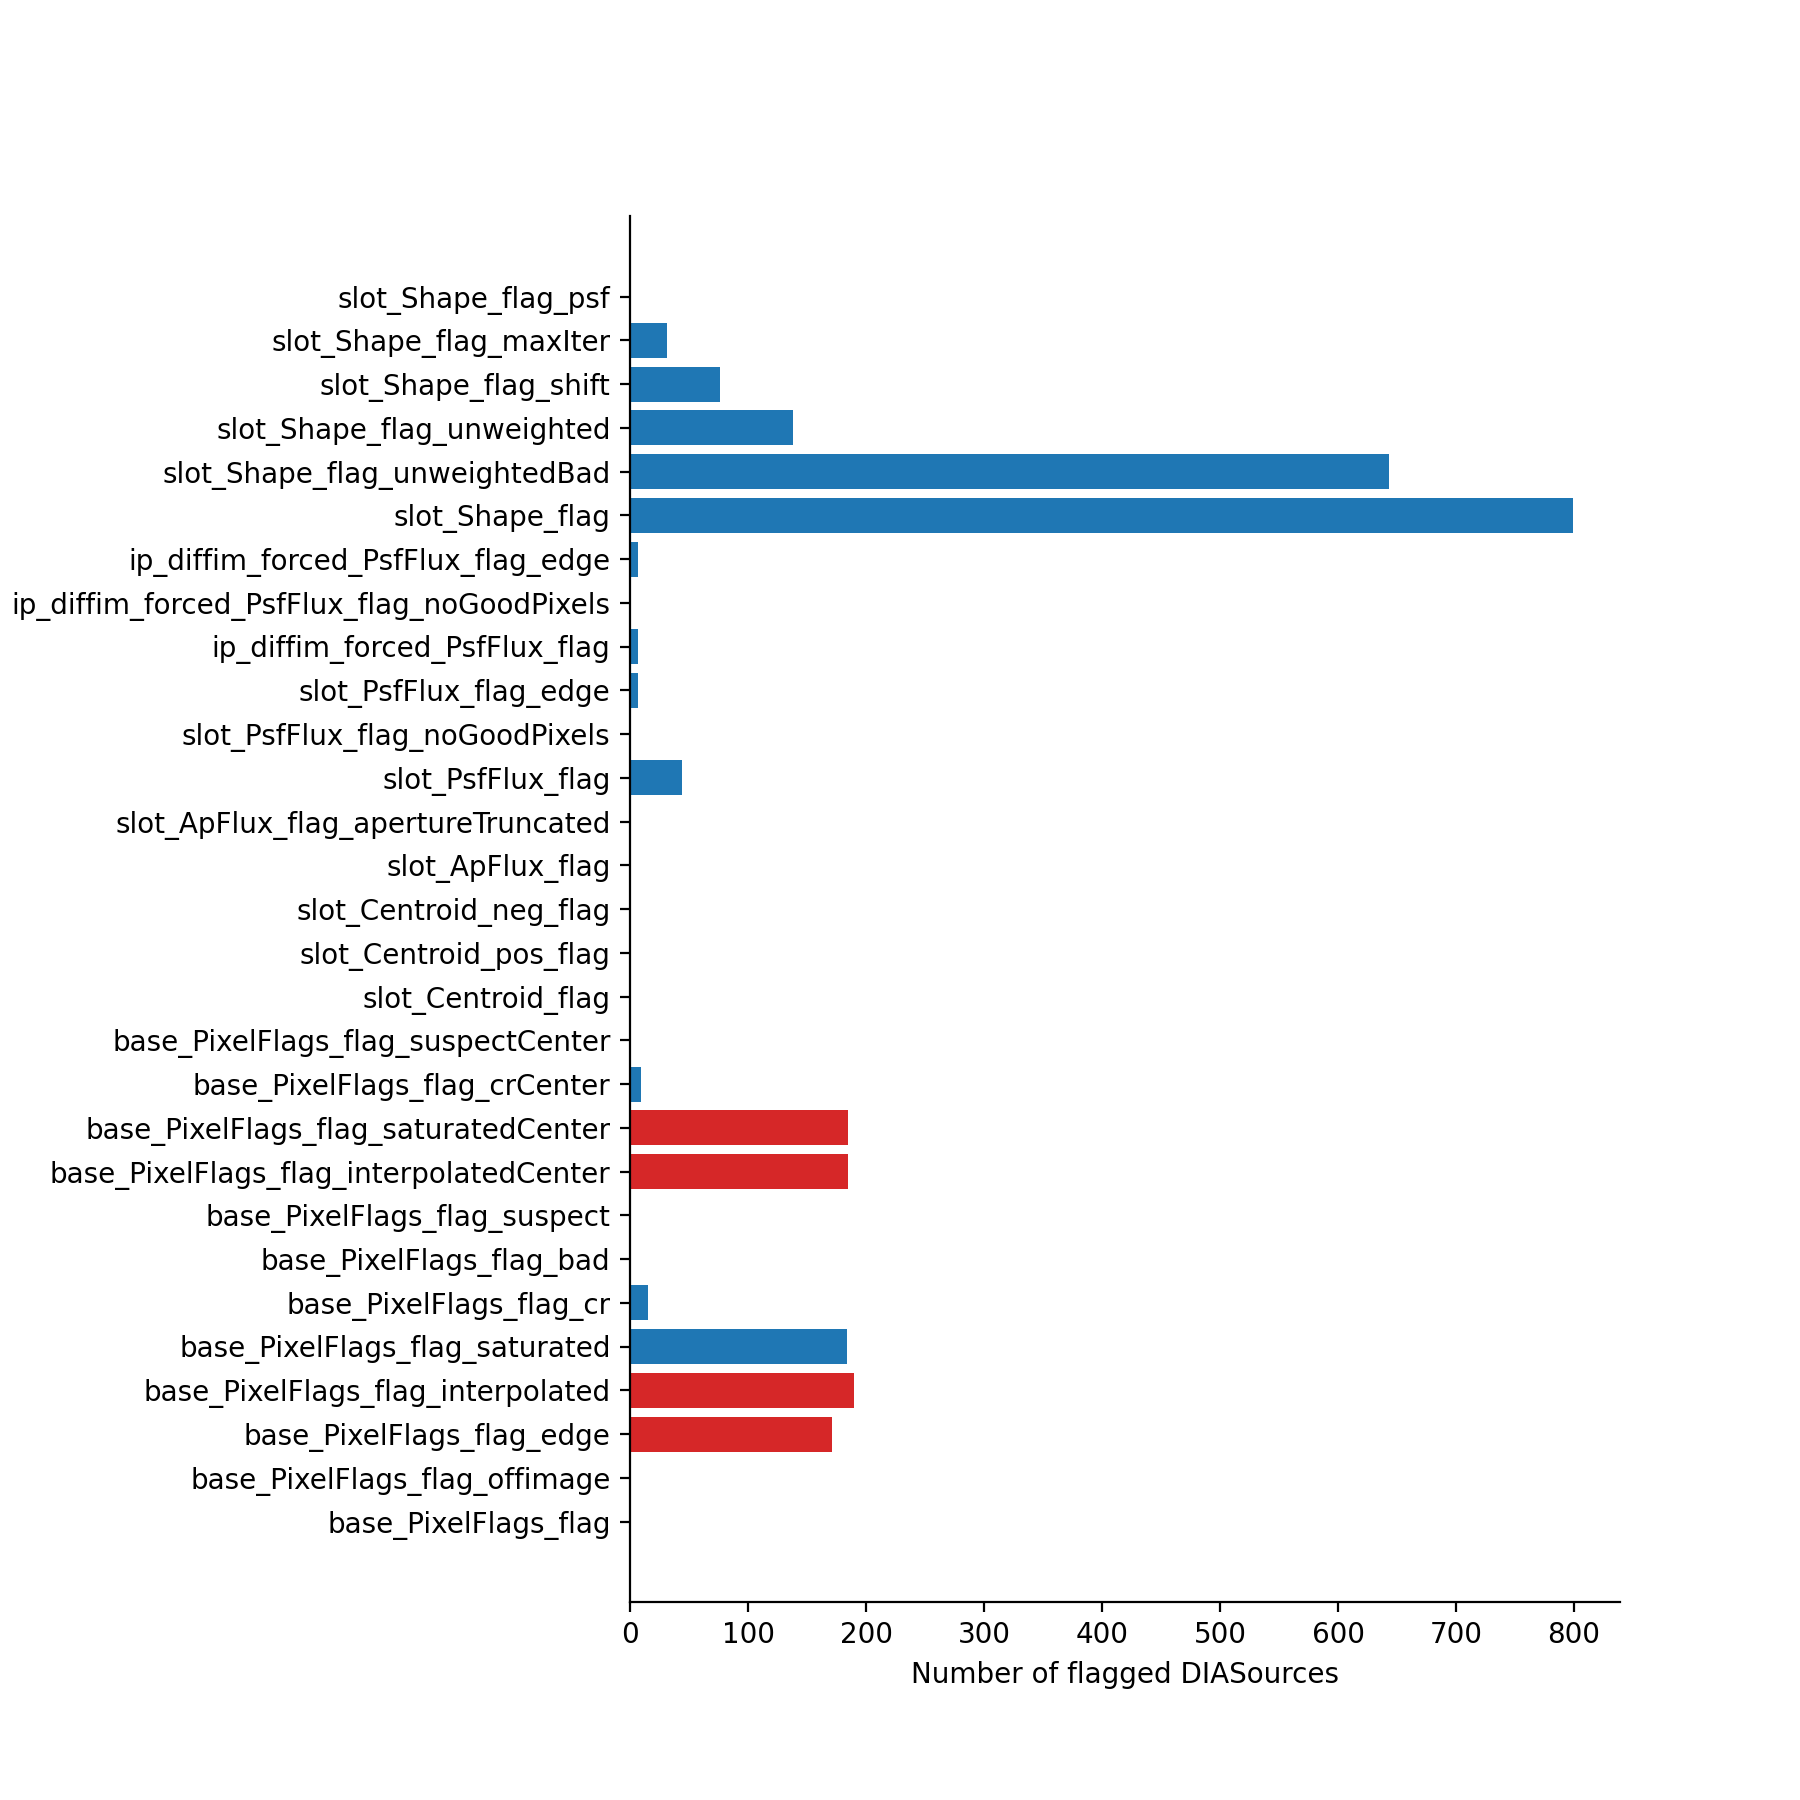

In [13]:
pla.plotFlagHist(srcTable, badFlagList=badFlagList)

<IPython.core.display.Javascript object>


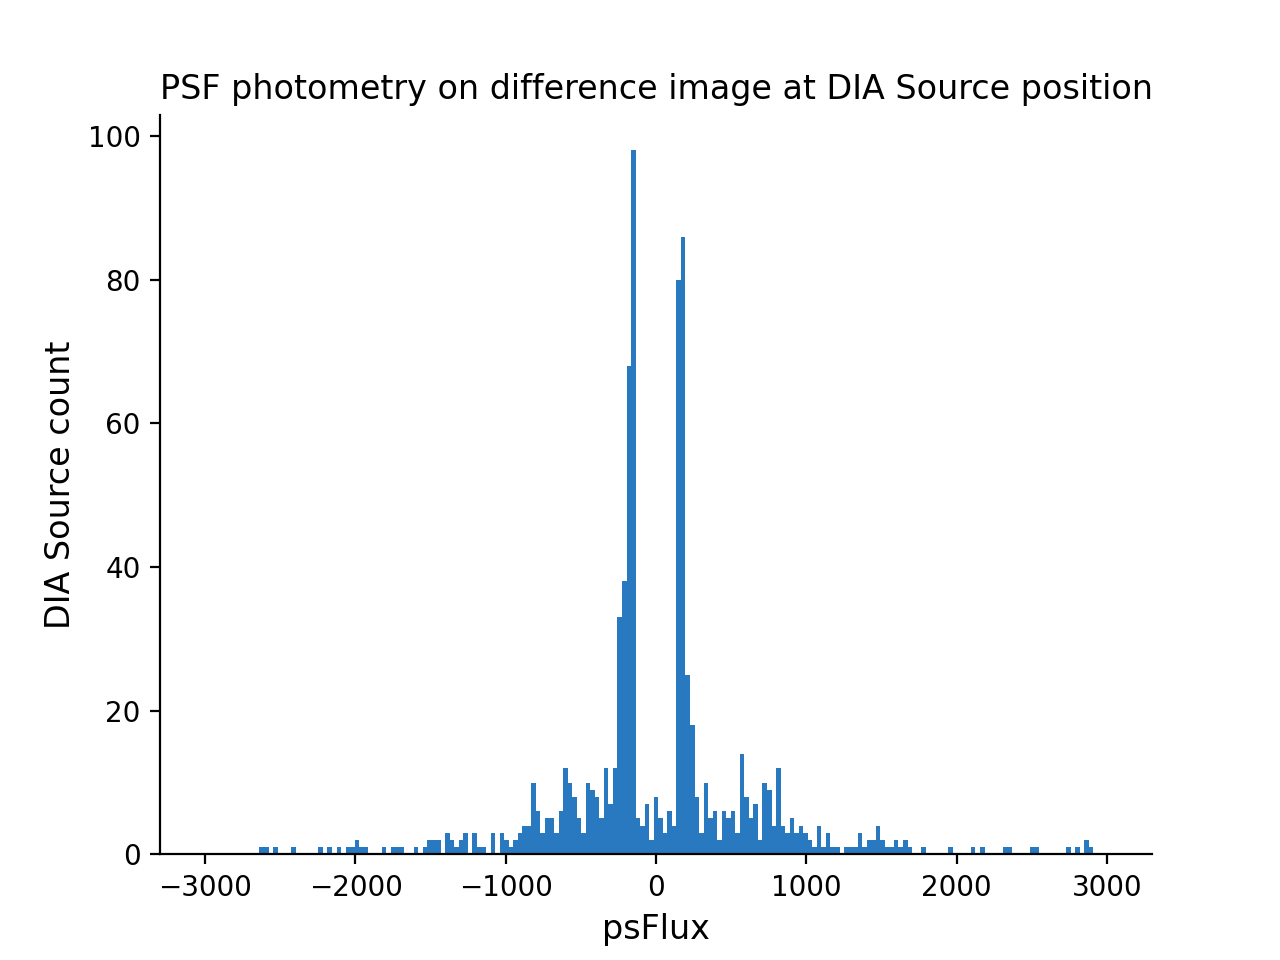

In [14]:
# Look at some DiaSource fluxes
pla.plotFluxHistSrc(srcTable, title='PSF photometry on difference image at DIA Source position')

## Examine the template coadd used for the patch we processed many visits for

And then examine one of several difference images that resulted

In [21]:
templateCoadd = butler.get('goodSeeingCoadd', collections=collection, tract=3829, patch=47,
                              band='g', skymap='DC2')

In [16]:
list(butler.registry.queryCollections('u/mrawls/DM-32035*'))

['u/mrawls/DM-32035-mini',
 'u/mrawls/DM-32035-mini/20211013T204128Z',
 'u/mrawls/DM-32035-big/20211014T210022Z',
 'u/mrawls/DM-32035-big']

In [17]:
# python equivalent of `butler query-datasets /repo/dc2 goodSeeingCoadd --collections=collection`
list(butler.registry.queryDatasets('goodSeeingCoadd', collections=collection))

[DatasetRef(DatasetType('goodSeeingCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'DC2', tract: 3829, patch: 47}, id=384d77e7-bd2b-43f0-b30a-b54ac568d8ff, run='u/mrawls/DM-30027-test2/20210522T004733Z')]

<IPython.core.display.Javascript object>


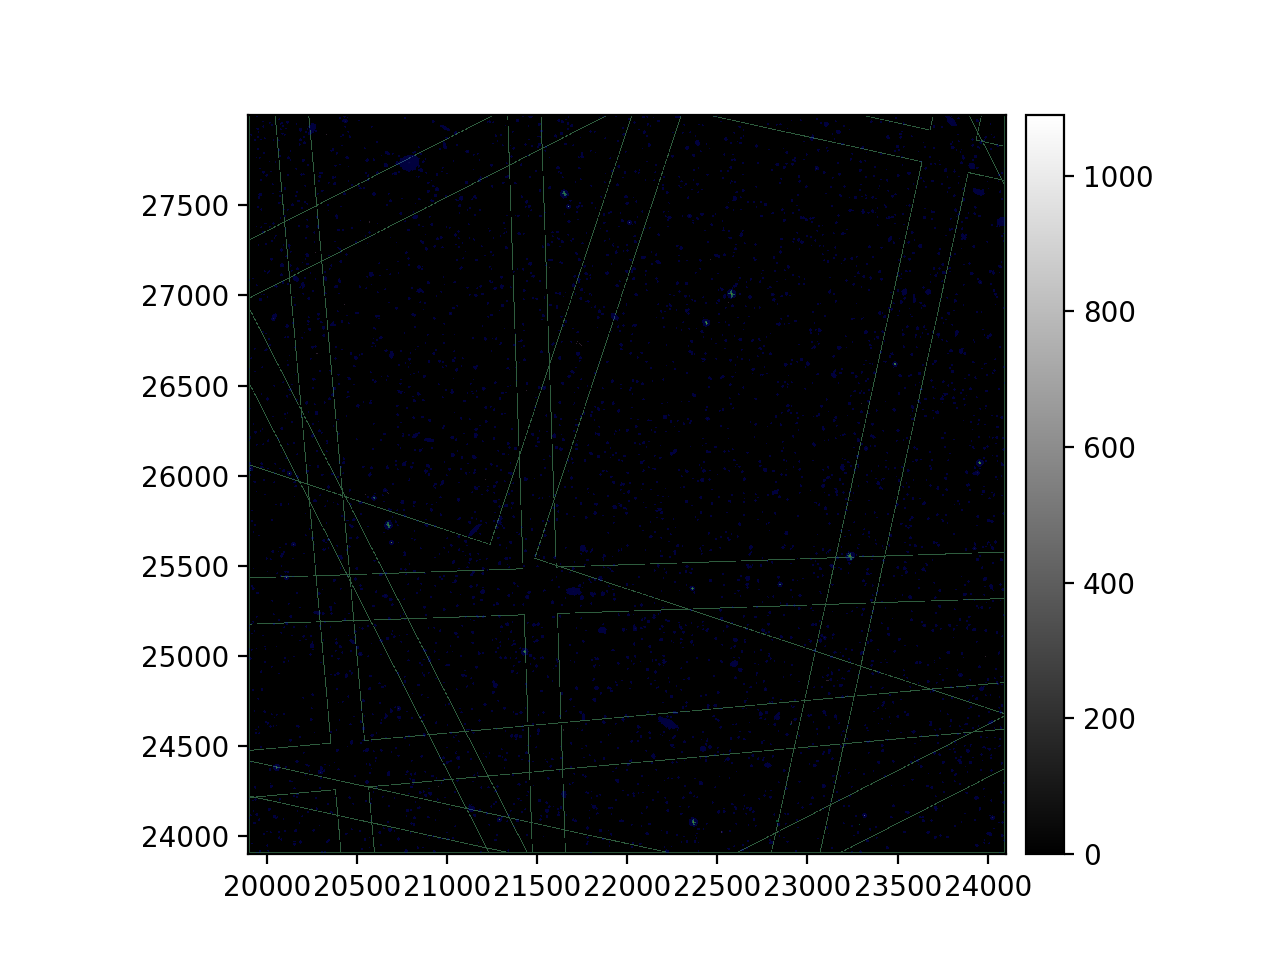

In [18]:
display1 = afwDisplay.Display(backend='matplotlib', frame=6)
#display1.setDefaultMaskTransparency(10)  # these things maybe work, but apply inconsistently, because afw
#display1.scale("linear", "zscale")
display1.mtv(templateCoadd)

In [23]:
# Try using firefly instead of matplotlib - it gives a link you click to open a plot in a new window!
display2 = afwDisplay.Display(backend='firefly', url='http://lsst-demo.ncsa.illinois.edu/firefly')
display2.getClient().get_firefly_url()

'http://lsst-demo.ncsa.illinois.edu/firefly/slate.html?__wsch=bXJhd2xzMjAyMS0xMC0yMA'

In [24]:
display2.mtv(templateCoadd)  # I swear this worked during the demo...!

HTTPError: Upload unsuccessful

In [25]:
# Couldn't get the ra/dec or x/y coordinates to plot in the firefly window, possibly wrong coordinate system?
# Yusra has an example where this works for an actual source catalog loaded via the Butler...
with display2.Buffering():
    for idx, row in goodSrc.iterrows():
        display2.dot('+', row.x, row.y, ctype='orange', size=20)

In [26]:
differenceExp = butler.get('goodSeeingDiff_differenceExp', band='g', collections=collection,
                           visit=159471, detector=148, instrument=instrument)

In [27]:
display2 = afwDisplay.Display(backend='firefly', url='http://lsst-demo.ncsa.illinois.edu/firefly')
display2.getClient().get_firefly_url()

'http://lsst-demo.ncsa.illinois.edu/firefly/slate.html?__wsch=bXJhd2xzMjAyMS0xMC0yMA'

In [28]:
display2.mtv(differenceExp)  # again, I promise this worked in real life

HTTPError: Upload unsuccessful

## Now that you've got a postgres APDB from a larger bps processing run...

You might find these steps useful!

* Once your AP Pipeline run is done, you will have things in the schema named `$USER` in the `lsstdevapdb1` postgres database
* **BEST PRACTICE:** Rename this schema to something related to your output collection, and create a new empty `$USER` schema so you are ready to go for your next AP Pipeline run
* To do this, replace `mrawls` with your username in the commands below:

```
psql "host=lsst-pg-devel1.ncsa.illinois.edu user=mrawls dbname=lsstdevapdb1"
alter schema mrawls rename to mrawls_collectionnameofyourchoice;
create schema mrawls authorization mrawls;
\q
```

In [29]:
repo = '/repo/dc2'  # this is the same as before
instrument = 'LSSTCam-imSim'  # also the same as before
collection = 'u/mrawls/DM-32035-big'
schema = 'mrawls'  # the name of the postgres schema the APDB corresponding to collection lives in
#schema = 'mrawls_dm32035big'  # what I probably should rename it to

objTable2, srcTable2, goodObj2, goodSrc2 = pla.loadTables(repo,
                                                      dbType='postgres',
                                                      dbName='lsstdevapdb1',
                                                      schema=schema,
                                                      gen='gen3',
                                                      instrument=instrument,
                                                      badFlagList=badFlagList)

# Note we are passing in `badFlagList` as an argument this time!

In [30]:
print(len(objTable2), len(srcTable2))

673 1116


### These are smaller than I expected, since we processed multiple patches this time

In [40]:
list(butler.registry.queryDataIds(['tract', 'patch'], datasets='goodSeeingDiff_differenceExp',
                                  collections='u/mrawls/DM-32035-big'))

[{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 22, tract: 3829, patch: 46, visit: 254379, ...},
 {instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 22, tract: 3829, patch: 47, visit: 254379, ...},
 {instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 22, tract: 3829, patch: 48, visit: 254379, ...},
 {instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 22, tract: 4026, patch: 0, visit: 254379, ...},
 {instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 22, tract: 4026, patch: 1, visit: 254379, ...},
 {instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 25, tract: 3829, patch: 33, visit: 254379, ...},
 {instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 25, tract: 3829, patch: 40, visit: 254379, ...},
 {instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 25, tract: 3829, patch: 41, visit: 254379, ...},
 {instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 25, tract: 3829, patch: 40, visit: 254379, ...},
 {instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 2

In [42]:
len(list(butler.registry.queryDataIds(['tract', 'patch'], datasets='goodSeeingDiff_differenceExp',
                                  collections='u/mrawls/DM-32035-big')))

339

In [39]:
len(list(butler.registry.queryDataIds(['tract', 'patch'], datasets='goodSeeingDiff_differenceExp',
                                  collections='u/mrawls/DM-32035-mini')))

339

In [44]:
list(butler.registry.queryDataIds(['tract', 'patch'], 
            datasets='goodSeeingDiff_differenceExp',
            collections='u/mrawls/DM-32035-mini')) == list(butler.registry.queryDataIds(['tract', 'patch'],
                                                                  datasets='goodSeeingDiff_differenceExp',
                                                                  collections='u/mrawls/DM-32035-big'))

True

I'm not entirely sure why the collections have the same difference images in them, since we constrained the "mini" run to just one patch and we didn't do the same for the "big" run. I **suspect** it's because I only built coadds in one patch in the collection we used as input for templates! That would also explain the handful of failed quanta we found with failed template lookups. This is just a demo, so I'm not going to worry too much about it.

The gist is, you can make all the same plots and do all the same analysis from data read in from a postgres APDB as you can from an sqlite APDB. The former can handle way bigger data volumes. Now, go forth and process data!

<IPython.core.display.Javascript object>


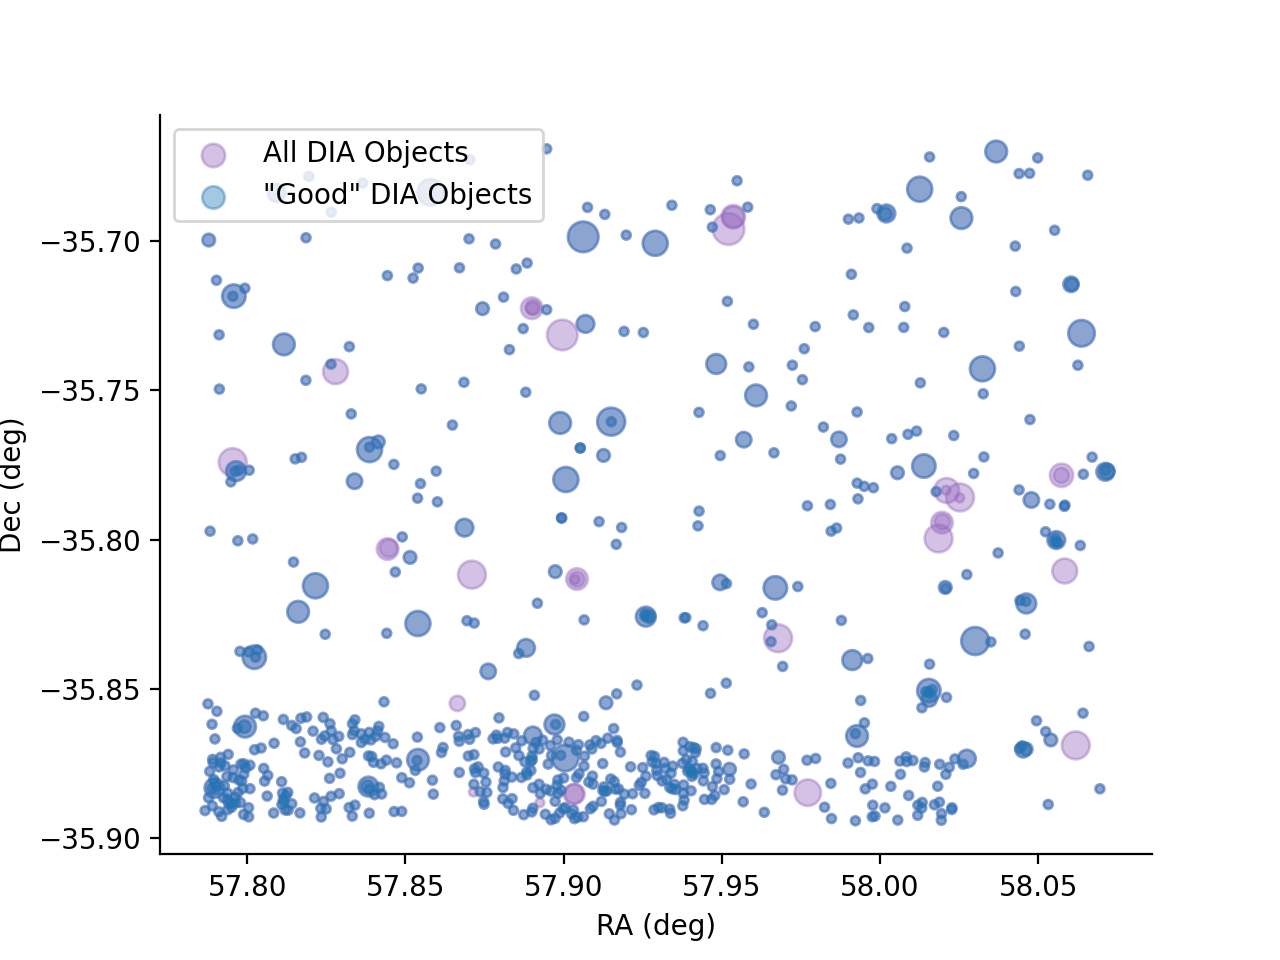

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(objTable2.ra, objTable2.decl, c='C4', s=objTable2['nDiaSources']*10,
           alpha=0.4, label='All DIA Objects')
ax.scatter(goodObj2.ra, goodObj2.decl, c='C0', s=goodObj2['nDiaSources']*10,
           alpha=0.4, label='"Good" DIA Objects')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
plt.legend()